In [13]:
from feature_engineering.Pipe import PipeLine,PipeUnion
from feature_engineering.data_process import *
from feature_engineering.feature_selection import *
import pandas as pd
import numpy as np

In [14]:
def get_x(path=None):
    path = r"D:\QQ\qqchatdata\295746332\FileRecv\第三次模拟\Molecular_Descriptor.xlsx" if path is None else path
    data = pd.read_excel(path)
    data = data.set_index("SMILES")
    return data

def get_y(path=None):
    path = r"D:\QQ\qqchatdata\295746332\FileRecv\第三次模拟\ERα_activity.xlsx" if path is None else path
    data = pd.read_excel(path)
    return data[['pIC50','SMILES']].set_index("SMILES")

def get_info(data):
    unique_value = data.nunique()
    dtypes = data.dtypes.apply(lambda x:x.name)
    null = data.isnull().sum(0)
    info = pd.concat([unique_value,dtypes,null],axis=1)
    info.columns = ["unique_value","dtypes","null"]
    return info

In [15]:
x = get_x()
y = get_y()

In [4]:
print(x.shape,y.shape)

(1974, 729) (1974, 1)


In [16]:
class DtypesSelector(BaseProcess):
    def __init__(self,dtypes,**kwargs):
        super().__init__(**kwargs)
        self.dtypes = dtypes
    
    def _transform(self,X,y=None):
        tmp = X.select_dtypes(include=self.dtypes)
        tmp = tmp.astype(dtype=self.dtypes)
        return tmp if y is None else (tmp,y)

class CateDetectOutlier(BaseProcess):
    def __init__(self,threshold=0.01,handle = 'nan',**kwargs):
        assert handle in ['drop','nan'],'handle must be drop or nan'
        super().__init__(**kwargs)
        self.threshold = threshold
        self.handle = handle
    
    def _transform(self,X,y=None):
        if 0<=self.threshold<1:
            threshold = int(X.shape[0]*self.threshold)
        else:
            threshold = self.threshold
        for col in list(X.columns):
            tmp = X[col].value_counts()
            tmp = tmp[tmp<threshold]
            match self.handle:
                case 'drop':
                    X = X[~X[col].isin(tmp.index)]
                case 'nan':
                    X[col] = X[col].apply(lambda x:np.nan if x in tmp.index else x)
                case _:
                    raise ValueError("handle must be drop or nan")
        return X if y is None else (X,y.loc[X.index])

pipe1 = PipeLine([DropNA(threshold=0.2)])
pipe_float = PipeLine([DtypesSelector(dtypes="float"),
                       FillNA(method='median'),
                       Scaler(method='robust'),
                       DetectOutlier(method='iqr',handle='nan'),
                       FillNA(method='median')])
pipe_int = PipeLine([DtypesSelector(dtypes="int")])
pipe_int_cat = PipeLine([CategorySelector(threshold=0.1),
                         FillNA(method='mode'),
                         CateDetectOutlier(threshold=0.001,handle='nan'),
                         FillNA(method='mode')
                         ])
pip_int_num = PipeLine([CategorySelector(threshold=0.1,drop=True),
                        FillNA(method='median'),
                        DetectOutlier(method='iqr',handle='nan'),
                        FillNA(method='median'),
                        Scaler(method='robust')])
pipe_int = PipeLine([('int',pipe_int),
                     ('parallel process',PipeUnion([('int_category',pipe_int_cat),
                                                    ('int_num',pip_int_num)])
                     )
                     ])

pipe2 = PipeUnion([('float_features',pipe_float),('int_features',pipe_int)])
pipe3 = PipeLine([('baseline',pipe1),('parallel process',pipe2),('transfer',TypeTransfer(to='float64'))])

In [17]:
x1,y1=pipe3.fit_transform(x,y)

In [18]:
pipe3

PipeLine(steps=[('baseline',
                 PipeLine(steps=[('dropna', DropNA(threshold=0.2))])),
                ('parallel process',
                 PipeUnion(transformer_list=[('float_features',
                                              PipeLine(steps=[('dtypesselector',
                                                               DtypesSelector(dtypes='float')),
                                                              ('fillna-1',
                                                               FillNA(method='median')),
                                                              ('scaler',
                                                               Scaler(cols=['ALogP',
                                                                            'ALogp2',
                                                                            'AMR',
                                                                            'apol',
                                                                            'ATSc1',
                                                                            'ATSc2',
                                                                            'ATSc3',
                                                                            'ATSc4',
                                                                            'ATSc5',
                                                                            'ATSm1',
                                                                            '...
                                                                                           ('int_num',
                                                                                            PipeLine(steps=[('categoryselector',
                                                                                                             CategorySelector(drop=True,
                                                                                                                              threshold=0.1)),
                                                                                                            ('fillna-1',
                                                                                                             FillNA(method='median')),
                                                                                                            ('detectoutlier',
                                                                                                             DetectOutlier(cols=Index(['ECCEN', 'WPATH'], dtype='object'),
                                                                                                                           handle='nan')),
                                                                                                            ('fillna-2',
                                                                                                             FillNA(method='median')),
                                                                                                            ('scaler',
                                                                                                             Scaler(cols=['ECCEN',
                                                                                                                          'WPATH',
                                                                                                                          'pIC50']))]))]))]))])),
                ('transfer', TypeTransfer(to='float64'))])

In [19]:
data1 = pd.concat([x1,y1],axis=1)
save_path = r"D:\QQ\qqchatdata\295746332\FileRecv\第三次模拟\preprocessed1.xlsx"
data1.to_excel(save_path)

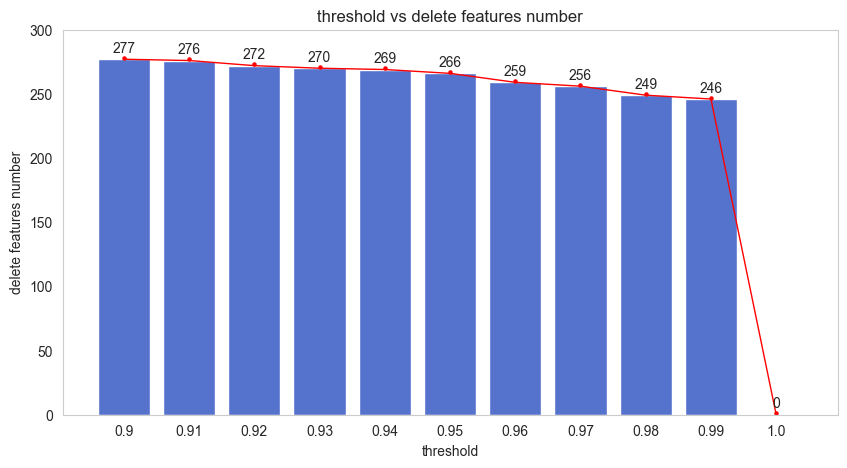

In [48]:
# 频数处理
path = r"D:\QQ\qqchatdata\295746332\FileRecv\第三次模拟\变量数值频数.csv"
data = pd.read_csv(path).T.drop('Unnamed: 0',axis=0).apply(lambda x:(x/x.sum()).max(),axis=1)
thresholds = np.arange(0.9,1+1e-6,0.01).tolist()
def apply_threshold(data,threshold):
    return data.loc[data<=threshold].index.tolist()
result = [len(data)-len(apply_threshold(data,threshold)) for threshold in thresholds]
tmp = pd.DataFrame({'threshold':thresholds,'result':result}).sort_values('threshold',ascending=True)
tmp['threshold'] = tmp['threshold'].apply(lambda x:round(x,2))
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax=plt.subplots(figsize=(10,5))
ax.set_xlabel('threshold')
ax.set_title('threshold vs delete features number')
sns.barplot(data=tmp,x='threshold',y='result',ax=ax,color='royalblue')
height = [i.get_height() for i in ax.patches]
width = [i.get_width()/2+i.get_x() for i in ax.patches]
assert len(height)==len(width)
for x,y in zip(width,height):
    y = int(y)
    ax.text(x,y+3,y,ha='center',va='bottom')
    ax.scatter(x,y+1,s=5,color='red')
for i in range(len(height)-1):
    ax.plot([width[i],width[i+1]],[height[i],height[i+1]],color='red',linewidth=1)
ax.set_ylabel('delete features number')
ax.set_ylim(0,300)
plt.grid(visible=False)
plt.show()
select_feat = apply_threshold(data,0.99)

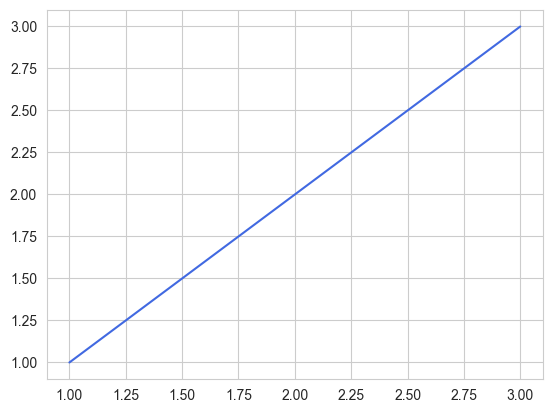

In [46]:
plt.plot([1,2,3],[1,2,3],c='royalblue')